LaTeX is installed.
pdfTeX 3.141592653-2.6-1.40.26 (TeX Live 2024)
kpathsea version 6.4.0
Copyright 2024 Han The Thanh (pdfTeX) et al.
There is NO warranty.  Redistribution of this software is
covered by the terms of both the pdfTeX copyright and
the Lesser GNU General Public License.
For more information about these matters, see the file
named COPYING and the pdfTeX source.
Primary author of pdfTeX: Han The Thanh (pdfTeX) et al.
Compiled with libpng 1.6.43; using libpng 1.6.43
Compiled with zlib 1.3.1; using zlib 1.3.1
Compiled with xpdf version 4.04

Total input power: 351.452 kW
Total input particle: 9.85649e+21 part/s


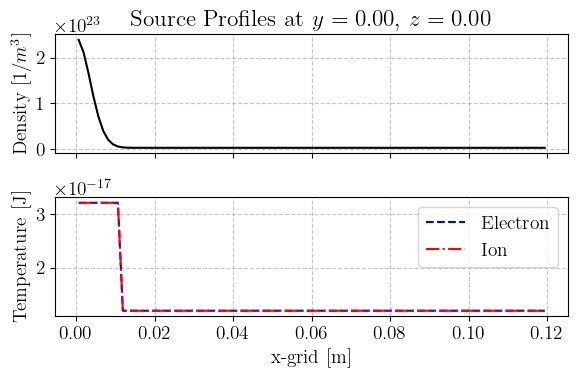

Time frames available from 0 to 231


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys

# Configure plotting
plt.rcParams["figure.figsize"] = (6,4)

# Custom libraries and routines
home_dir = os.path.expanduser("~")
sys.path.append(home_dir+'/personal_gkyl_scripts/python_utilities')
from classes import Simulation, Species
from utils import *

simdir = '../sim_data_dir_example/3x2v_example/gk_tcv_posD_iwl_3x2v_electron_heating/'
fileprefix = 'gk_tcv_posD_iwl_3x2v_D02'

simulation = Simulation(dimensionality='3x2v')
simulation.set_phys_param(
    B_axis = 1.4,           # Magnetic field at magnetic axis [T]
    eps0 = 8.854e-12,       # Vacuum permittivity [F/m]
    eV = 1.602e-19,         # Elementary charge [C]
    mp = 1.673e-27,         # Proton mass [kg]
    me = 9.109e-31,         # Electron mass [kg]
)
def qprofile(x):
    return 5 + 0.5*x

simulation.set_geom_param(
    R_axis      = 0.8727315068,         # Magnetic axis major radius
    Z_axis      = 0.1414361745,         # Magnetic axis height
    R_LCFSmid   = 1.0968432365089495,   # Major radius of LCFS at the midplane
    a_shift     = 0.25,                 # Parameter in Shafranov shift
    kappa       = 1.5,                 # Elongation factor
    delta       = 0.3,                 # Triangularity factor
    qprofile    = qprofile,             # Safety factor
    x_LCFS      = 0.04,                 # position of the LCFS (= core domain width)
    x_out       = 0.08                  # SOL domain width
)
# Define the species
ion = Species(name='ion',
              m=2.01410177811*simulation.phys_param.mp, # Ion mass
              q=simulation.phys_param.eV,               # Ion charge [C]
              T0=100*simulation.phys_param.eV, 
              n0=2.0e19)
elc = Species(name='elc',
              m=simulation.phys_param.me, 
              q=-simulation.phys_param.eV, # Electron charge [C]
              T0=100*simulation.phys_param.eV, 
              n0=2.0e19)
# Add them to the simulation (we need to know this before setting up the data parameters)
simulation.add_species(ion)
simulation.add_species(elc)
# This call will set up the data structure of the simulation and set up a large dictionary 
# conaining the receipes of many post processing quantities, see simulation.data_param.info()
simulation.set_data_param( simdir = simdir, fileprefix = fileprefix, species = simulation.species)
# This is the first call that will load data. 
simulation.geom_param.load_metric(simulation.data_param.fileprefix)
# If the paths are not set up correctly, the script will fail here.
n_srcOMP=2.4e23
x_srcOMP=0.0
Te_srcOMP=2 * simulation.species['elc'].T0
Ti_srcOMP=2 * simulation.species['ion'].T0
sigma_srcOMP=0.03 * simulation.geom_param.Lx
floor_src=1e-2
def custom_density_src_profile(x,y,z):
    return n_srcOMP * (np.exp(-((x - x_srcOMP) ** 2) / (2.0 * sigma_srcOMP ** 2)) + floor_src)
def custom_temp_src_profile_elc(x, y = None, z = None):
    mask = x < (x_srcOMP + 3 * sigma_srcOMP)
    fout = np.empty_like(x)
    fout[mask] = Te_srcOMP; fout[~mask] = Te_srcOMP * 3.0 / 8.0
    return fout  
def custom_temp_src_profile_ion( x, y = None, z = None):
    mask = x < (x_srcOMP + 3 * sigma_srcOMP)
    fout = np.empty_like(x)
    fout[mask] = Ti_srcOMP; fout[~mask] = Ti_srcOMP * 3.0 / 8.0
    return fout   
simulation.set_OMPsources(n_srcOMP=n_srcOMP,x_srcOMP=x_srcOMP,
                          Te_srcOMP=Te_srcOMP,Ti_srcOMP=Ti_srcOMP,
                          sigma_srcOMP=sigma_srcOMP,floor_src=floor_src,
                          density_src_profile=custom_density_src_profile,
                          temp_src_profile_elc=custom_temp_src_profile_elc,
                          temp_src_profile_ion=custom_temp_src_profile_ion)
simulation.get_input_power(type='profile')
simulation.get_input_particle()
simulation.OMPsources.plot(x_grid=simulation.geom_param.grids[0],y_const=0,z_const=0)
simulation.normalize('t','mus') # time in micro-seconds
simulation.normalize('x','minor radius') # radial coordinate normalized by the minor radius (rho=r/a)
simulation.normalize('y','Larmor radius') # binormal in term of reference sound Larmor radius
simulation.normalize('z','pi') # parallel angle devided by pi
simulation.normalize('fluid velocities','thermal velocity') # fluid velocity moments are normalized by the thermal velocity
simulation.normalize('temperatures','eV') # temperatures in electron Volt
simulation.normalize('pressures','Pa') # pressures in Pascal
simulation.normalize('energies','MJ') # energies in mega Joules

fieldname = fileprefix+'-field' #e.g. we check the electrostatic field files.
sim_frames = find_available_frames(simulation,fieldname)
print("Time frames available from %g to %g"%(sim_frames[0],sim_frames[-1]))

In [2]:
# Here we compute the integral using the first DG coeff and a Riemann sum.
import postgkyl as pg
# load the M2e diag of the source
data = pg.GData(simdir+fileprefix+'-elc_source_M2_0.gkyl')
# get the coefficient of the expansion
vth2_e = data.get_values()
# take only the first coefficient divided by sqrt(2)^cdim
vth2_e = vth2_e[:,:,:,0]/np.sqrt(2)**3
# load the M2i diag of the source
data = pg.GData(simdir+fileprefix+'-ion_source_M2_0.gkyl')
# get the coefficient of the expansion
vth2_i = data.get_values()
# take only the first coefficient
vth2_i = vth2_i[:,:,:,0]/np.sqrt(2)**3
# do the same for the Jacobian
data = pg.GData(simdir+fileprefix+'-jacobgeo.gkyl')
Jacobian = data.get_values()[:,:,:,0]/np.sqrt(2)**3

# interpolate the data to the grid
grid = data.get_grid()
# get the values of the grid
x = grid[0][:-1]
y = grid[1][:-1]
z = grid[2][:-1]
# build the integrant
integrant = (0.5*elc.m*vth2_e + 0.5*ion.m*vth2_i)*Jacobian
# integrate with Riemann sum
integral = (x[1]-x[0])*(y[1]-y[0])*(z[1]-z[0])*np.sum(integrant)
print('Total power: ',integral/1e3,'kW')

Total power:  416.5736247415801 kW


In [3]:
# Here we compute the integral using the Frame class and the integral surf.
from classes import Frame
from tools import math_tools as mt
M2e = Frame(simulation,'M2e_src',0)
M2e.load()
integrant = 0.5*elc.m*M2e.values*simulation.geom_param.Jacobian

M2i = Frame(simulation,'M2i_src',0)
M2i.load()
integrant += 0.5*ion.m*M2i.values*simulation.geom_param.Jacobian

# integrate (trapz)
integral = mt.integral_vol(simulation.geom_param.grids[0],simulation.geom_param.grids[1],simulation.geom_param.grids[2],integrant)
print('Total power: ',integral/1e3,'kW')

Total power:  351.4524797341096 kW


In [4]:
# Here we compute the integral using the Frame class and the volume integral
from classes import Frame
from tools import math_tools as mt
M2e = Frame(simulation,'M2e_src',0)
M2e.load()
M2e_int = M2e.compute_volume_integral()
integral = 0.5*elc.m*M2e_int

M2i = Frame(simulation,'M2i_src',0)
M2i.load()
M2i_int = M2i.compute_volume_integral()
integral += 0.5*ion.m*M2i_int

print('Total power: ',integral/1e3,'kW')

Total power:  351.4524797341096 kW


In [5]:
n_srcOMP=2.4e23
x_srcOMP=0.0
Te_srcOMP=2 * simulation.species['elc'].T0
Ti_srcOMP=2 * simulation.species['ion'].T0
sigma_srcOMP=0.03 * simulation.geom_param.Lx
floor_src=1e-2
def custom_density_src_profile(x,y,z):
    return n_srcOMP * (np.exp(-((x - x_srcOMP) ** 2) / (2.0 * sigma_srcOMP ** 2)) + floor_src)
def custom_temp_src_profile_elc(x, y = None, z = None):
    mask = x < (x_srcOMP + 3 * sigma_srcOMP)
    fout = np.empty_like(x)
    fout[mask] = Te_srcOMP; fout[~mask] = Te_srcOMP * 3.0 / 8.0
    return fout  
def custom_temp_src_profile_ion( x, y = None, z = None):
    mask = x < (x_srcOMP + 3 * sigma_srcOMP)
    fout = np.empty_like(x)
    fout[mask] = Ti_srcOMP; fout[~mask] = Ti_srcOMP * 3.0 / 8.0
    return fout   

from tools import math_tools as mt
[X,Y,Z] = mt.custom_meshgrid(simulation.geom_param.grids[0],simulation.geom_param.grids[1],simulation.geom_param.grids[2])

nsrc = custom_density_src_profile(X,Y,Z)
Tesrc = custom_temp_src_profile_elc(X,Y,Z)
Tisrc = custom_temp_src_profile_ion(X,Y,Z)
srcpow = 1.5 * nsrc * (Tesrc + Tisrc)
integrant = srcpow * simulation.geom_param.Jacobian
lin_pow = mt.integral_vol(simulation.geom_param.grids[0],simulation.geom_param.grids[1],simulation.geom_param.grids[2],integrant[:,:,:])
print('Total power: ',lin_pow/1e3,'kW')

Total power:  396.0091752133157 kW
